[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samrajsahota/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Solution Started
Device to be Used for LSTM Training is: mps
Processing dataset: tensorflow
Run 1/30 for tensorflow
Run 2/30 for tensorflow
Run 3/30 for tensorflow
Run 4/30 for tensorflow
Run 5/30 for tensorflow
Run 6/30 for tensorflow
Run 7/30 for tensorflow
Run 8/30 for tensorflow
Run 9/30 for tensorflow
Run 10/30 for tensorflow
Run 11/30 for tensorflow
Run 12/30 for tensorflow
Run 13/30 for tensorflow
Run 14/30 for tensorflow
Run 15/30 for tensorflow
Run 16/30 for tensorflow
Run 17/30 for tensorflow
Run 18/30 for tensorflow
Run 19/30 for tensorflow
Run 20/30 for tensorflow
Run 21/30 for tensorflow
Run 22/30 for tensorflow
Run 23/30 for tensorflow
Run 24/30 for tensorflow
Run 25/30 for tensorflow
Run 26/30 for tensorflow
Run 27/30 for tensorflow
Run 28/30 for tensorflow
Run 29/30 for tensorflow
Run 30/30 for tensorflow
Results for tensorflow:
    Accuracy  Precision    Recall  F1-Score   AUC-ROC                 Model  \
0   0.550336   0.625616  0.695691  0.531337  0.695691  Naïve Bay

,Dataset,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC,Run
0,Combined,BERT + LSTM,0.756199,0.663085,0.742003,0.665443,0.742003,15.5
1,Combined,Naïve Bayes + TF-IDF,0.672821,0.647180,0.767494,0.618774,0.767494,15.5
2,caffe,BERT + LSTM,0.812069,0.588679,0.603501,0.584332,0.603501,15.5
3,caffe,Naïve Bayes + TF-IDF,0.537356,0.570511,0.658870,0.475966,0.658870,15.5
4,incubator-mxnet,BERT + LSTM,0.774757,0.632090,0.719744,0.639391,0.719744,15.5
5,incubator-mxnet,Naïve Bayes + TF-IDF,0.592233,0.609264,0.743632,0.534078,0.743632,15.5
6,keras,BERT + LSTM,0.736070,0.661770,0.711048,0.659680,0.711048,15.5
7,keras,Naïve Bayes + TF-IDF,0.591542,0.643402,0.716084,0.570746,0.716084,15.5
8,pytorch,BERT + LSTM,0.784327,0.633502,0.701675,0.636948,0.701675,15.5
9,pytorch,Naïve Bayes + TF-IDF,0.644812,0.616224,0.759297,0.571025,0.759297,15.5


AllTable Saved

 Overall Performance Table


,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC,Run
0,BERT + LSTM,0.771532,0.641277,0.697207,0.642420,0.697207,15.5
1,Naïve Bayes + TF-IDF,0.598277,0.619876,0.725018,0.550654,0.725018,15.5


OverallTable Saved


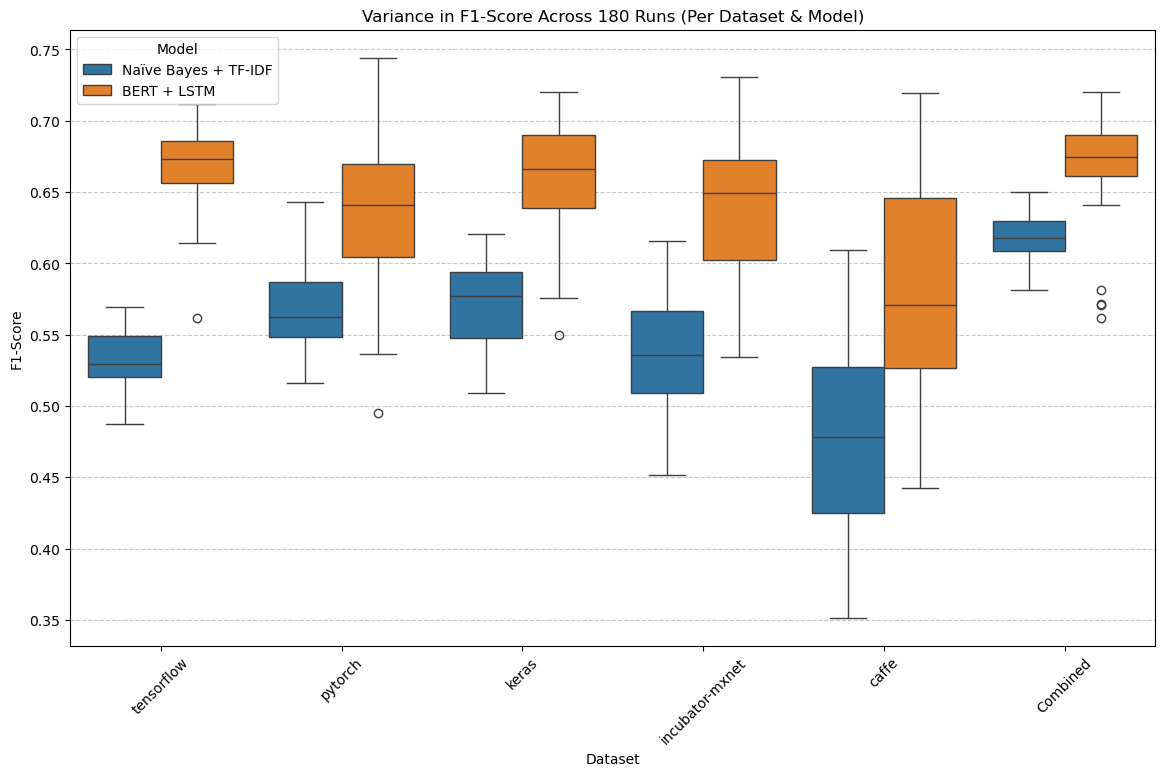

BoxPlot Saved
           Dataset  Wilcoxon p-value  Paired t-Test p-value
0       tensorflow      1.862645e-09           9.364693e-19
1          pytorch      5.548261e-04           1.164923e-04
2            keras      2.607703e-08           3.601955e-09
3  incubator-mxnet      2.607703e-08           4.521827e-10
4            caffe      3.725290e-09           1.706309e-09
5         Combined      9.902567e-05           7.399924e-06
6  Overall Average      1.089849e-04           2.064967e-05
Stats Results Saved
Solution Finished


In [2]:
# Master Imports
import os
import re
import numpy as np
import pandas as pd
import gc

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')  # Ensure stopwords are available

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score)
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertTokenizer

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import wilcoxon,ttest_rel


# Cleaning Baseline Data
def Clean_Baseline_Data(DATASETS_PATH,OUTPUT_FOLDER):
    # Load dataset filenames
    dataset_files = [file for file in os.listdir(DATASETS_PATH) if file.endswith('.csv')]
    
    # Define required columns from baseline
    REQUIRED_COLUMNS = ['Repository', 'Number', 'Body', 'class', 'Title']
    
    # Load datasets
    datasets = {}
    for file in dataset_files:
        project_name = file.split('.')[0]
        df = pd.read_csv(os.path.join(DATASETS_PATH, file))
        
        # Select only required columns
        df = df[REQUIRED_COLUMNS]
        
        # Store in dictionary
        datasets[project_name] = df
    
    # Merge all datasets into one DataFrame for combined dataset
    combined_dataset = pd.concat(datasets.values(), ignore_index=True)
    
    # Check the total number of rows in the combined dataset
    total_rows = combined_dataset.shape[0]
    class_1_count = combined_dataset[combined_dataset['class'] == 1].shape[0]
    class_0_count = combined_dataset[combined_dataset['class'] == 0].shape[0]

    # Display the counts
    print(f"Total rows: {total_rows}")
    print(f"Rows where class = 1 (performance bug-related): {class_1_count}")
    print(f"Rows where class = 0 (not performance bug-related): {class_0_count}")
    
    
    # Define text cleaning functions
    def remove_html(text):
        return re.sub(r'<.*?>', '', str(text))
    
    def remove_emoji(text):
        emoji_pattern = re.compile("[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF\U00002702-\U000027B0\U000024C2-\U0001F251]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', str(text))
    
    CUSTOM_STOPWORDS = ['...', 'im', 'ive', 'dont', 'doesnt', 'didnt', 'cant', 'couldnt', 'shouldnt']
    STOPWORDS = set(stopwords.words('english') + CUSTOM_STOPWORDS)
    
    def clean_text(text):
        if not isinstance(text, str):
            return ""
        text = text.lower()
        text = remove_html(text)
        text = remove_emoji(text)
        text = re.sub(r"[^a-z0-9\s.,!?']", " ", text)
        text = " ".join([word for word in text.split() if word not in STOPWORDS])
        return text.strip()
    
    # Apply cleaning function to each dataset
    for project, df in datasets.items():
        df['Body'] = df['Body'].astype(str).apply(clean_text)
        df['Title'] = df['Title'].astype(str).apply(clean_text)
        df['Combined_Text'] = df['Title'] + " " + df['Body']
        
        # Save processed dataset
        output_path = os.path.join(OUTPUT_FOLDER, f"Preprocessed_Baseline_{project}.csv")
        df.to_csv(output_path, index=False)
        print(f"Saved: {output_path}")
    
    # Apply cleaning to combined dataset
    combined_dataset['Body'] = combined_dataset['Body'].astype(str).apply(clean_text)
    combined_dataset['Title'] = combined_dataset['Title'].astype(str).apply(clean_text)
    combined_dataset['Combined_Text'] = combined_dataset['Title'] + " " + combined_dataset['Body']
    
    # Save combined dataset
    combined_output_path = os.path.join(OUTPUT_FOLDER, "Preprocessed_Baseline_Combined.csv")
    combined_dataset.to_csv(combined_output_path, index=False)
    print(f"Saved: {combined_output_path}")


# Cleaning My Design Data
def Clean_BERT_Data(DATASETS_PATH,BERT_OUTPUT_FOLDER):
    # Load dataset filenames
    dataset_files = [file for file in os.listdir(DATASETS_PATH) if file.endswith('.csv')]
    
    # Define required columns from baseline
    REQUIRED_COLUMNS = ['Repository', 'Number', 'Body', 'class', 'Title']
    
    # Load datasets
    datasets = {}
    for file in dataset_files:
        project_name = file.split('.')[0]
        df = pd.read_csv(os.path.join(DATASETS_PATH, file))
        
        # Select only required columns
        df = df[REQUIRED_COLUMNS]
        
        # Store in dictionary
        datasets[project_name] = df
    
    # Merge all datasets into one DataFrame for combined dataset
    combined_dataset = pd.concat(datasets.values(), ignore_index=True)
    
    # Check the total number of rows in the combined dataset
    total_rows = combined_dataset.shape[0]
    class_1_count = combined_dataset[combined_dataset['class'] == 1].shape[0]
    class_0_count = combined_dataset[combined_dataset['class'] == 0].shape[0]
    
    # Display the counts
    print(f"Total rows: {total_rows}")
    print(f"Rows where class = 1 (performance bug-related): {class_1_count}")
    print(f"Rows where class = 0 (not performance bug-related): {class_0_count}")
    
    # Process each dataset with BERT tokenizer
    for project, df in datasets.items():
        df['Combined_Text'] = df['Title'] + " " + df['Body']
       
        # Save processed dataset
        output_path = os.path.join(BERT_OUTPUT_FOLDER, f"Preprocessed_BERT_{project}.csv")
        df.to_csv(output_path, index=False)
        print(f"Saved: {output_path}")
    
    # Process combined dataset
    combined_dataset['Combined_Text'] = combined_dataset['Title'] + " " + combined_dataset['Body']
    
    
    # Save combined dataset
    combined_output_path = os.path.join(BERT_OUTPUT_FOLDER, "Preprocessed_BERT_Combined.csv")
    combined_dataset.to_csv(combined_output_path, index=False)
    print(f"Saved: {combined_output_path}")
    

# Define function to split dataset and match rows across Baseline & BERT data
def split_and_match_data(dataset_name,base_data_path,bert_data_path,testSize,run):
    """
    Splits the Baseline dataset into training/testing sets and finds matching rows in BERT dataset
    using 'Repository' and 'Number' as unique identifiers.
    """

    # Free memory to stop issues
    torch.cuda.empty_cache()
    gc.collect()
    torch.mps.empty_cache()
    
    # Load baseline dataset (TF-IDF + Naïve Bayes data)
    baseline_path = f"{base_data_path}Preprocessed_Baseline_{dataset_name}.csv"
    bert_path = f"{bert_data_path}/Preprocessed_BERT_{dataset_name}.csv"

    baseline_df = pd.read_csv(baseline_path)
    bert_df = pd.read_csv(bert_path)

    bert_df = bert_df.drop_duplicates(subset=["Repository", "Number"], keep="first")
    baseline_df = baseline_df.drop_duplicates(subset=["Repository", "Number"], keep="first")



    # Ensure data consistency: Convert 'Repository' and 'Number' to string for exact matching
    baseline_df["Repository"] = baseline_df["Repository"].astype(str)
    baseline_df["Number"] = baseline_df["Number"].astype(str)
    bert_df["Repository"] = bert_df["Repository"].astype(str)
    bert_df["Number"] = bert_df["Number"].astype(str)

    # Perform train-test split on the Baseline dataset 
    train_baseline, test_baseline = train_test_split(baseline_df, test_size=testSize, random_state=run, stratify=baseline_df["class"])



    # Use 'Repository' + 'Number' as keys to find the same rows in BERT dataset
    train_keys = set(zip(train_baseline["Repository"], train_baseline["Number"]))
    test_keys = set(zip(test_baseline["Repository"], test_baseline["Number"]))

    # Match rows in the BERT dataset
    train_bert = bert_df[bert_df.apply(lambda row: (row["Repository"], row["Number"]) in train_keys, axis=1)]
    test_bert = bert_df[bert_df.apply(lambda row: (row["Repository"], row["Number"]) in test_keys, axis=1)]

    # Ensure datasets are correctly aligned
    assert len(train_baseline) == len(train_bert), "Training sets do not match in size!"
    assert len(test_baseline) == len(test_bert), "Testing sets do not match in size!"

    # Free memory to stop issues
    torch.cuda.empty_cache()
    gc.collect()
    torch.mps.empty_cache()
    
    return train_baseline, test_baseline, train_bert, test_bert

    
# Baseline Training + Results
def train_and_evaluate_baseline(train_baseline, test_baseline):
    """
    Vectorizes text using TF-IDF, trains a Naïve Bayes model, and evaluates it on the test set.
    
    Returns:
    - Dictionary containing Accuracy, Precision, Recall, F1-Score, and AUC-ROC.
    """
    
    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))  
    X_train = vectorizer.fit_transform(train_baseline['Combined_Text'])
    X_test = vectorizer.transform(test_baseline['Combined_Text'])
    
    y_train, y_test = train_baseline['class'], test_baseline['class']
    

    #Hyperparameter Tuning via GridSearchCV
    param_grid = {'var_smoothing': np.logspace(-12, 0, 13)}
    grid = GridSearchCV(GaussianNB(), param_grid, cv=5, scoring='roc_auc')
    grid.fit(X_train.toarray(), y_train)
    
    # Train best model
    best_gnb = grid.best_estimator_
    best_gnb.fit(X_train.toarray(), y_train)
    
    # Predict
    y_pred = best_gnb.predict(X_test.toarray())

    fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)    
    # Compute Metrics
    results = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="macro"),
        "Recall": recall_score(y_test, y_pred, average="macro"),
        "F1-Score": f1_score(y_test, y_pred, average="macro"),
        "AUC-ROC": auc(fpr, tpr)
    }
    
    return results


# BERT + LSTM Training + Results
# Define the BERT + LSTM model
class BertLSTMClassifier(nn.Module):
    def __init__(self, bert_model_name, lstm_hidden_size, num_classes, dropout):

        super(BertLSTMClassifier, self).__init__()
        
        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained(bert_model_name)
        for param in self.bert.encoder.layer[-4:].parameters():  
            param.requires_grad = True  # Fine-tune last 4 layers

        
        # LSTM layer for sequence modeling
        self.lstm = nn.LSTM(input_size=768, hidden_size=lstm_hidden_size, num_layers=3, batch_first=True, bidirectional=True, dropout=0.3)
        self.norm = nn.LayerNorm(768) # Layer Normalization to stabilize training

        # Fully connected classifier
        self.fc = nn.Linear(lstm_hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, embeddings):
        # Ensure embeddings have 3D shape
        if embeddings.dim() == 2:  
            embeddings = embeddings.unsqueeze(1)  

        embeddings = self.norm(embeddings) # Normalize embeddings before passing to LSTM
        lstm_output, _ = self.lstm(embeddings)

        output = self.dropout(lstm_output[:, -1, :]) # Take the output from the last time step
        logits = self.fc(output) # Fully connected layer for final classification output
        return logits 

# Custom dataset class for BERT + LSTM training
class BugReportDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings #Initialisies
        self.labels = labels.clone().detach()  
    def __len__(self):
        return len(self.labels) #Number of samples

    def __getitem__(self, idx):
        return {
            "input_embeddings": self.embeddings[idx], #return embeddings and labels for index
            "labels": self.labels[idx]
        }

# Function to train and evaluate BERT + LSTM model
def train_and_evaluate_bert_lstm(train_bert, test_bert,device, batch_size, epochs, learning_rate,bert_model_name, lstm_hidden_size, num_classes, dropout,bert_model,model,tokenizer):
    """
    Trains and evaluates the BERT + LSTM model.
    Returns:
    - Dictionary containing Accuracy, Precision, Recall, F1-Score, and AUC-ROC.
    """
    # Free memory to stop issues
    gc.collect()  
    torch.mps.empty_cache() 

    #Extract Text Data for Embedding Generation
    train_texts = train_bert["Combined_Text"].tolist()
    test_texts = test_bert["Combined_Text"].tolist()

     #Generate BERT Embeddings for training and testing data
    train_embeddings = get_bert_embeddings(train_texts, tokenizer, bert_model, device)
    test_embeddings = get_bert_embeddings(test_texts, tokenizer, bert_model, device)

    # Free memory to stop issues
    del bert_model
    gc.collect()
    torch.mps.empty_cache()


    # Convert Data into PyTorch Dataset Format
    train_dataset = BugReportDataset(
        embeddings=train_embeddings,  
        labels=torch.tensor(train_bert["class"].tolist(), dtype=torch.long).to(device)
    )

    test_dataset = BugReportDataset(
        embeddings=test_embeddings, 
        labels=torch.tensor(test_bert["class"].tolist(), dtype=torch.long).to(device)
    )

    #Create DataLoaders for Efficient Training & Evaluation
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Free memory to stop issues
    torch.cuda.empty_cache()
    gc.collect()
    torch.mps.empty_cache()

    # Initialize optimizer,class weights and loss function
    model = BertLSTMClassifier(bert_model_name, lstm_hidden_size, num_classes, dropout=dropout)
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    classes = np.array([0, 1])  # Two classes: 0 (non-bug), 1 (bug), class weights make predictions more balanced and less on the majority
    class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=train_bert["class"].tolist())
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)  

    # Free memory to stop issues
    torch.cuda.empty_cache()
    gc.collect()
    torch.mps.empty_cache()
    
    # Train the model
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad() #Reset Gradients to Prevent Accumulation
            
            input_embeddings = batch["input_embeddings"].to(device)   #Move data to GPU for Faster Computation
            labels = batch["labels"].to(device)
            
            outputs = model(input_embeddings)   #Forward Pass - Generate Predictions
 
            loss = criterion(outputs, labels)#Compute Loss 
    
            loss.backward() #Backward Pass - Compute Gradients
            optimizer.step() #Update Model Weights
           
            total_loss += loss.detach()  

            

        #print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

    # Evaluate the model
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    
    with torch.no_grad():
        for batch in test_loader:

            #Move Batch Data to GPU for Faster Evaluation
            input_embeddings = batch["input_embeddings"].to(device)  
            labels = batch["labels"].to(device)

            with torch.autocast(device_type="mps", dtype=torch.float16):
                outputs = model(input_embeddings)  #Forward Pass - Generate Predictions Without Updating Weights

            probs = torch.sigmoid(outputs[:, 1]).cpu().numpy() # Convert Model Outputs to Probabilities
            preds = torch.argmax(outputs, dim=1).cpu().numpy() # Get Final Class Predictions
            labels = batch["labels"].cpu().numpy()   # ✅ Extract True Labels

            # Store Predictions & Probabilities for Later Evaluation
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels)

    fpr, tpr, _ = roc_curve(all_labels,all_preds, pos_label=1)
    # Compute Metrics
    results = {
        "Accuracy": accuracy_score(all_labels, all_preds),
        "Precision": precision_score(all_labels, all_preds, average="macro"),
        "Recall": recall_score(all_labels, all_preds, average="macro"),
        "F1-Score": f1_score(all_labels, all_preds, average="macro"),
        "AUC-ROC": auc(fpr, tpr)
    }

    # Free memory to stop issues
    torch.cuda.empty_cache()
    gc.collect()
    torch.mps.empty_cache()

    return results


def get_bert_embeddings(text_list, tokenizer, model, device):
    """Compute BERT embeddings for a list of texts."""
    model.eval()  #Set BERT to evaluation mode
    embeddings = []


    with torch.no_grad(): 
        
        for text in text_list:

            if not isinstance(text, str):  # Convert non-string values to empty string
                text = ""

            #Tokenize Input Text Using BERT
            inputs = tokenizer(text, max_length=256, padding="max_length", truncation=True, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}

            bert_output = model(**inputs)
            embeddings.append(bert_output.pooler_output.cpu())  #Store CPU version for efficiency
            
    return torch.stack(embeddings)  #Return all embeddings as a tensor





#Results Func
def Results(results_df):
    
    #Per-Dataset Performance Table (Average Metrics Per Dataset & Model)
    per_dataset_performance = results_df.groupby(["Dataset", "Model"]).mean(numeric_only=True).reset_index()
    print("\n Per-Dataset Performance Table")
    display(per_dataset_performance)
    per_dataset_performance.to_csv("AllTables.csv", index=False)
    print("AllTable Saved")
    
    # Overall Performance Table (Averaging Metrics Across All 180 Runs)
    overall_performance = results_df.groupby(["Model"]).mean(numeric_only=True).reset_index()
    print("\n Overall Performance Table")
    display(overall_performance)
    overall_performance.to_csv("OverallTables.csv", index=False)
    print("OverallTable Saved")
    
    
    
    
    # Boxplots for Variance Across 180 Runs (For F1-Score Per Dataset & Model)
    plt.figure(figsize=(14, 8))
    sns.boxplot(x="Dataset", y="F1-Score", hue="Model", data=results_df)
    plt.title("Variance in F1-Score Across 180 Runs (Per Dataset & Model)")
    plt.xlabel("Dataset")
    plt.ylabel("F1-Score")
    plt.xticks(rotation=45)
    plt.legend(title="Model")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.savefig("BoxPlot.png")

    # Show the plot
    plt.show()
    print("BoxPlot Saved")

#Stats Func 
def Statistical_Testing(results_df):
    # List of datasets
    datasets = results_df["Dataset"].unique()
    
    
    # Store Wilcoxon & Paired t-Test results
    statistical_results = []
    
    # Perform Statitical Tests  per dataset
    for dataset in datasets:
        # Filter data for the dataset
        dataset_results = results_df[results_df["Dataset"] == dataset]
        
        # Extract F1-Scores for each model across the 30 runs
        f1_lstm = dataset_results[dataset_results["Model"] == "BERT + LSTM"]["F1-Score"].values
        f1_nb = dataset_results[dataset_results["Model"] == "Naïve Bayes + TF-IDF"]["F1-Score"].values
    
       
    
        wilcoxon_p, ttest_p = None, None
    
        # Ensure we have valid paired samples
        if len(f1_lstm) == len(f1_nb) and len(f1_lstm) > 0:
            wilcoxon_stat, wilcoxon_p = wilcoxon(f1_lstm, f1_nb)
            ttest_stat, ttest_p = ttest_rel(f1_lstm, f1_nb)
            
        statistical_results.append({"Dataset": dataset,"Wilcoxon p-value": wilcoxon_p,"Paired t-Test p-value": ttest_p})
        
    
    # Convert results to DataFrame
    statistical_df = pd.DataFrame(statistical_results)
    average_row = {"Dataset": "Overall Average","Wilcoxon p-value": statistical_df["Wilcoxon p-value"].mean(),"Paired t-Test p-value": statistical_df["Paired t-Test p-value"].mean()}
    statistical_df = pd.concat([statistical_df, pd.DataFrame([average_row])], ignore_index=True)

    print(statistical_df)
    statistical_df.to_csv("Statistical_testing_results.csv", index=False)
    print("Stats Results Saved")

# MASTER RUN
def Master_Run(all_datasets,DATASETS_PATH,BASE_OUTPUT_FOLDER,BERT_OUTPUT_FOLDER,testSize,batch_size,epochs,learning_rate,bert_model_name,lstm_hidden_size,num_classes,dropout,NUM_RUNS):
    
    os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
    torch.backends.cuda.matmul.allow_tf32 = False
    torch.backends.cudnn.allow_tf32 = False
    gc.collect()
    torch.mps.empty_cache()
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print("Device to be Used for LSTM Training is: "+ str(device))
    
    Clean_Baseline_Data(DATASETS_PATH,BASE_OUTPUT_FOLDER)
    Clean_BERT_Data(DATASETS_PATH,BERT_OUTPUT_FOLDER)
    print("Data Cleaned & Saved to Folders")

    gc.collect()
    torch.mps.empty_cache()
    
    # Store results
    all_results = []

    #Load Tokenizier and bert model and initialise Model
    tokenizer = BertTokenizer.from_pretrained(bert_model_name)
    bert_model = BertModel.from_pretrained(bert_model_name).to(device)  

    model = BertLSTMClassifier(bert_model_name, lstm_hidden_size, num_classes, dropout=dropout)
    model.to(device)

    # Loop through each dataset
    for dataset in all_datasets:
        print(f"Processing dataset: {dataset}")
    
        for run in range(NUM_RUNS):
            
            print(f"Run {run+1}/{NUM_RUNS} for {dataset}")
    
          
            # Split data
            train_base, test_base, train_bert, test_bert = split_and_match_data(dataset,BASE_OUTPUT_FOLDER,BERT_OUTPUT_FOLDER,testSize,run)
            
            # Train and evaluate Baseline model (Naïve Bayes + TF-IDF)
            baseline_results = train_and_evaluate_baseline(train_base, test_base)
            baseline_results["Model"] = "Naïve Bayes + TF-IDF"
            baseline_results["Dataset"] = dataset
            baseline_results["Run"] = run + 1
            all_results.append(baseline_results)
    
            # Train and evaluate BERT + LSTM model
            bert_results = train_and_evaluate_bert_lstm(train_bert, test_bert,device,batch_size,epochs,learning_rate,bert_model_name,lstm_hidden_size,num_classes,dropout,bert_model,model,tokenizer)
            bert_results["Model"] = "BERT + LSTM"
            bert_results["Dataset"] = dataset
            bert_results["Run"] = run + 1
            all_results.append(bert_results)

   

    
    # Convert results to DataFrame
    results_df = pd.DataFrame(all_results)
    results_df.head
    results_df.to_csv("experiment_results.csv", index=False)
    print("Experiment Results Saved")
 
    
    
    # Load the experiment results from CSV file
    experiment_results_path = "experiment_results.csv"  
    results_df = pd.read_csv(experiment_results_path)
    Results(results_df)
    Statistical_Testing(results_df)





#MANUAL SETTINGS
DATASETS_PATH = "Datasets/" # MANUAL Create folder in root and add data as CSVs (5 in total, 
                            # with the names: "tensorflow", "pytorch", "keras", "incubator-mxnet", "caffe"

BASE_OUTPUT_FOLDER = "Preprocessed_Baseline/" #MANUAL Create folder in root
BERT_OUTPUT_FOLDER = "Preprocessed_BERT/" #MANUAL Create folder in root
testSize = 0.2
batch_size=64
epochs=100
learning_rate=3e-5
bert_model_name="bert-base-uncased"
lstm_hidden_size=512
num_classes=2
dropout=0.3
NUM_RUNS = 30
all_datasets = ["tensorflow", "pytorch", "keras", "incubator-mxnet", "caffe", "Combined"]

#Please only Edit the Dataset_Path, the Base_Output_Folder & the BERT_output_folder
#Please check all imports are available in the environment, and it is recommended to be using GPU not CPU to do this (it will say what it is using when you run, 'MPS' is Apples Macs GPU)
print("Solution Started")
Master_Run(all_datasets,DATASETS_PATH,BASE_OUTPUT_FOLDER,BERT_OUTPUT_FOLDER,testSize,batch_size,epochs,learning_rate,bert_model_name,lstm_hidden_size,num_classes,dropout,NUM_RUNS)
print("Solution Finished")
#Your Results will be in your root folder. You will have the following:
#Experiment Results Table - Data for each individual run (180 rows)
#AllTables - Average Resutls for each Dataset/Combined for both models (12 rows)
#Overall Table - Average Resutls for both models (2 rows)
#BoxPlot.png - F1 Score Box plot for each model & Dataset/Combined, showing variance across the 30 runs (12 Box Plots)
#Statistical_testing_results table - F1 Score Statistical Tests, Wilcoxon value & Paired t-Test value for each dataset/combined and each model alongside the averages for all 6 values  (7 rows)





Total rows: 3712
Rows where class = 1 (performance bug-related): 607
Rows where class = 0 (not performance bug-related): 3105
Saved: Preprocessed_Baseline/Preprocessed_Baseline_pytorch.csv
Saved: Preprocessed_Baseline/Preprocessed_Baseline_caffe.csv
Saved: Preprocessed_Baseline/Preprocessed_Baseline_keras.csv
Saved: Preprocessed_Baseline/Preprocessed_Baseline_tensorflow.csv
Saved: Preprocessed_Baseline/Preprocessed_Baseline_incubator-mxnet.csv
Saved: Preprocessed_Baseline/Preprocessed_Baseline_Combined.csv
